# Exploring the hierarchical model with a pareto distribution

The aim of this notebook is to explore using the hierarchical model to fit very simple distributions that are *similar* to the MRP. This should be faster and easier to muck around with than the full MRP, and give similar results.

First we define a few functions for generating data in a pareto distribution:


$$ g(\theta, m) = A m^{-(\alpha+1)} $$

$$ q(\theta, m) = A m_{\rm min}^{-\alpha}/\alpha $$

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from mrpy.fit_perobj import _stan_cache

In [5]:
a = 0.8
mmin = 1e3
N = 1e5

In [6]:
def rpareto(xmin,a,N):
    return xmin/np.random.random(N)**(1.0/a)

/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


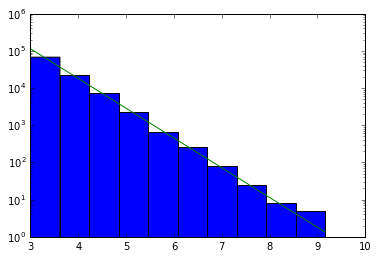

In [4]:
counts,bins,_ = plt.hist(np.log10(rpareto(mmin,a,N)))
logm = np.linspace(np.log10(mmin),bins.max(),50)
A = N *a/ (mmin**-a)
plt.plot(logm,A*10**(-logm*a)*np.log(10)*(bins[1]-bins[0]))
plt.yscale('log')

## Simple PyStan Model

In [7]:
simple_model="""
functions {
  real wpareto_log(vector logx,real logx_min,real alpha,real lnA){
    return sum(lnA + log(log(10))-alpha*logx*log(10)) - exp(lnA)*pow(10,-logx_min*alpha)/alpha;
  }  
}
data {
  int<lower=0> N;
  vector[N] logx;
  
  real<lower=0> alpha_min;
  real<lower=0> alpha_max;
  real lnA_min;
  real lnA_max;
}
transformed data {
  real logx_min;
  logx_min <- min(logx);
}
parameters {
  real<lower=lnA_min,upper=lnA_max> lnA;
  real<lower=alpha_min,upper=alpha_max> alpha;
}
model {
  logx ~ wpareto(logx_min, alpha, lnA);
}
"""

In [8]:
def run_simple(alpha,mmin,N,alpha_bounds=(0.1,4)):
    logx = np.log10(rpareto(mmin,alpha,int(N)))
    true_lnA = np.log( N *alpha/ (mmin**-alpha))
    lnA_bounds = (np.log( N *alpha_bounds[0]/ (mmin**-alpha_bounds[0])),
                  np.log( N *alpha_bounds[1]/ (mmin**-alpha_bounds[1])))

    data = {"N":int(N),
            "logx":logx,
            "alpha_min":alpha_bounds[0],
            "alpha_max":alpha_bounds[1],
            "lnA_min":lnA_bounds[0],
            "lnA_max":lnA_bounds[1]}
    
    model = _stan_cache(model_name="pareto_simple", model_code=simple_model)
    
    fit = model.optimizing(data=data)
    return fit, model, data, true_lnA

In [57]:
fit,model,data, true_lnA = run_simple(1.5,1e4,8e3)
print fit
print '"True": ', true_lnA, 1.5

(7.605645764865546, 47.214852669686593)
Using cached StanModel
OrderedDict([(u'lnA', array(23.08977433351133)), (u'alpha', array(1.4879776406085483))])
"True":  23.2081724867 1.5


Apparently this can't fit things with fewer than 8e3 particles???

## More complex...

First we define a function which can sample the distribution and cut it correctly:

In [9]:
def get_sample(mmin,alpha,lnA, sd=0.3):

    low_mmin = mmin - sd*4
    N = np.exp(lnA)*10**(-alpha*mmin)/alpha
    
    low_N = (10**low_mmin/10**mmin)**-alpha * N

    underlying = np.log10(rpareto(10**low_mmin,alpha,int(low_N)))
    
    observed = np.random.normal(underlying,sd)
    
    observed = observed[observed>mmin]
    
    return observed,underlying

In [10]:
def run_simple_on_complex(alpha,mmin,lnA,sd=0.3,alpha_bounds=(0.1,4)):
    logx,underlying = get_sample(mmin,alpha,lnA,sd)
    
    lnA_bounds = (lnA-10,lnA+10)

    data = {"N":len(logx),
            "logx":logx,
            "alpha_min":alpha_bounds[0],
            "alpha_max":alpha_bounds[1],
            "lnA_min":lnA_bounds[0],
            "lnA_max":lnA_bounds[1]}
    
    model = _stan_cache(model_name="pareto_simple", model_code=simple_model)
    
    fit = model.optimizing(data=data)
    
    counts,bins,_ = plt.hist(logx,histtype='step',bins=40)
    plt.hist(underlying,histtype='step',bins=bins)
    logm = np.linspace(mmin,bins.max(),50)
    plt.plot(logm,np.exp(lnA)*10**(-logm*alpha)*np.log(10)*(bins[1]-bins[0]),label="Underlying")
    plt.plot(logm,np.exp(fit['lnA'])*10**(-logm*fit['alpha'])*np.log(10)*(bins[1]-bins[0]),label="Fit")
    plt.legend(loc=0)
    plt.yscale('log')


    return fit, model, data

Using cached StanModel
OrderedDict([(u'lnA', array(31.486603592925633)), (u'alpha', array(0.807879743822218))]) 31.0920137134


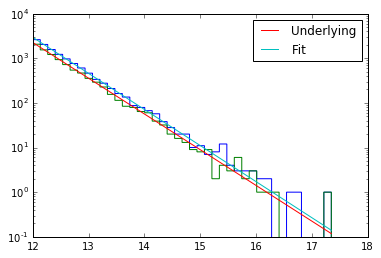

In [164]:
fit,model,data = run_simple_on_complex(0.8,12.0,31.0,0.4)
print fit, true_lnA

Actually, the normalisation is pretty poor here, since things are being up-scattered into the region of interest. We should try to fix that, by letting $m_{\rm min}$ vary?

In [20]:
hierarchical_model_fixed_mmin="""
functions {
  real wpareto_log(vector logx,real logx_min,real alpha,real lnA){
    return sum(lnA + log(log(10))-alpha*logx*log(10)) - exp(lnA)*pow(10,-logx_min*alpha)/alpha;
  }  
}
data {
  int<lower=0> N;
  vector[N] logx_meas;
  real std;
  
  real<lower=0> alpha_min;
  real<lower=0> alpha_max;
  real lnA_min;
  real lnA_max;
  
  real logx_min;
}
//transformed data {
//  real logx_min;
//  logx_min <- min(logx);
//}
parameters {
  real<lower=lnA_min,upper=lnA_max> lnA;
  real<lower=alpha_min,upper=alpha_max> alpha;
  vector<lower=10,upper=18>[N] logx;
//  real logx_min; 
}
model {
  logx ~ wpareto(logx_min, alpha, lnA);
  for (i in 1:N)
      logx[i] ~ normal(logx_meas[i],std)T[10,18];
}
"""

hierarchical_model_variable_mmin="""
functions {
  real wpareto_log(vector logx,real logx_min,real alpha,real lnA){
    return sum(lnA + log(log(10))-alpha*logx*log(10)) - exp(lnA)*pow(10,-logx_min*alpha)/alpha;
  }
}
data {
  int<lower=0> N;
  vector[N] logx_meas;
  real std;
  
  real<lower=0> alpha_min;
  real<lower=0> alpha_max;
  real lnA_min;
  real lnA_max;
}
parameters {
  real<lower=lnA_min,upper=lnA_max> lnA;
  real<lower=alpha_min,upper=alpha_max> alpha;
  real logx_min; 
  vector<lower=logx_min>[N] logx;
}
model {
  logx ~ wpareto(logx_min, alpha, lnA);
  for (i in 1:N)
      logx[i] ~ normal(logx_meas[i],std)T[logx_min,];
}
"""

hierarchical_model_variable_mmin_pdf="""
data {
  int<lower=0> N;
  vector[N] logx_meas;
  real std;
  
  real<lower=0> alpha_min;
  real<lower=0> alpha_max;
}
parameters {
  real<lower=alpha_min,upper=alpha_max> alpha;
  real logx_min; 
  vector<lower=logx_min>[N] logx;
}
model {
  for (i in 1:N){
      pow(10,logx[i]) ~ pareto(pow(10,logx_min), alpha);
      logx[i] ~ normal(logx_meas[i],std)T[logx_min,];
  }
}
"""

In [12]:
def get_sample_old(mmin,alpha,lnA, sd=0.3):
    N = np.exp(lnA)*10**(-alpha*mmin)/alpha
    
    underlying = np.log10(rpareto(10**mmin,alpha,int(N)))
    
    observed = np.random.normal(underlying,sd)
    
    return observed,underlying

In [13]:
def run_hierarchical_on_complex(alpha,mmin,lnA,model=hierarchical_model_variable_mmin,sd=0.3,alpha_bounds=(0.1,4),old_style=False,**kwargs):
    if not old_style:
        logx,underlying = get_sample(mmin,alpha,lnA,sd)
    else:
        logx, underlying = get_sample_old(mmin,alpha,lnA,sd)
        assert model==hierarchical_model_variable_mmin or model==hierarchical_model_variable_mmin_pdf
        
    lnA_bounds = (lnA-10,lnA+10)
    
    if model==hierarchical_model_fixed_mmin:
        data = {"N":len(logx),
                "logx_meas":logx,
                "std":sd,
                "alpha_min":alpha_bounds[0],
                "alpha_max":alpha_bounds[1],
                "lnA_min":lnA_bounds[0],
                "lnA_max":lnA_bounds[1],
                'logx_min':mmin}
        pars = ['lnA','alpha']
        
    elif model==hierarchical_model_variable_mmin:
        data = {"N":len(logx),
                "logx_meas":logx,
                "std":sd,
                "alpha_min":alpha_bounds[0],
                "alpha_max":alpha_bounds[1],
                "lnA_min":lnA_bounds[0],
                "lnA_max":lnA_bounds[1]}
        pars = ['lnA','alpha','logx_min']
    elif model==hierarchical_model_variable_mmin_pdf:
        data = {"N":len(logx),
                "logx_meas":logx,
                "std":sd,
                "alpha_min":alpha_bounds[0],
                "alpha_max":alpha_bounds[1]}
        pars = ['alpha','logx_min']
        
    model = _stan_cache(model_name="pareto_hierarchical", model_code=model)
    
    
    fit = model.sampling(data=data,pars=pars,**kwargs)
    
    out = np.mean(fit.get_posterior_mean(),axis=0)
    
    counts,bins,_ = plt.hist(logx,histtype='step',bins=40)
    plt.hist(underlying,histtype='step',bins=bins)
    logm = np.linspace(mmin,bins.max(),50)
    plt.plot(logm,np.exp(lnA)*10**(-logm*alpha)*np.log(10)*(bins[1]-bins[0]),label="Underlying")
    plt.plot(logm,np.exp(out[0])*10**(-logm*out[1])*np.log(10)*(bins[1]-bins[0]),label="Fit")
    plt.legend(loc=0)
    plt.yscale('log')


    return fit, model, data, underlying

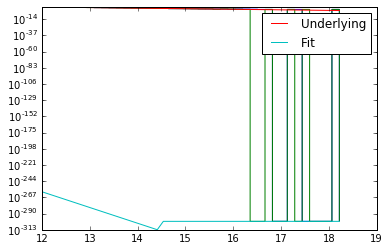

In [16]:
fit,model,data = run_hierarchical_on_complex(0.8,12.0,31.0,hierarchical_model_variable_mmin,0.4,iter=500,warmup=100,chains=4,n_jobs=4)

In [17]:
fit

Inference for Stan model: pareto_hierarchical_f463e51480396d35ad46274be0339770.
4 chains, each with iter=500; warmup=100; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lnA        41.0  8.8e-4 3.3e-3  40.99   41.0   41.0   41.0   41.0   14.0   1.11
alpha      0.92  2.3e-3 9.3e-3   0.91   0.92   0.92   0.93   0.95   17.0   1.25
logx_min   14.9    0.04   0.15  14.42  14.88  14.94  14.98  15.05   17.0   1.26
lp__      8.9e4   53.42 220.27  8.9e4  8.9e4  8.9e4  8.9e4  9.0e4   17.0   1.24

Samples were drawn using NUTS(diag_e) at Mon May 16 13:19:21 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Using cached StanModel


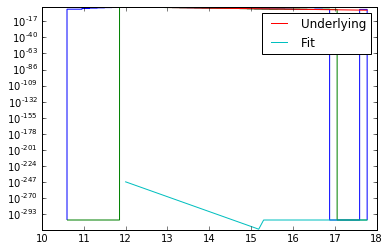

In [22]:
fit_old,model_old,data_old = run_hierarchical_on_complex(0.8,12.0,31.0,hierarchical_model_variable_mmin,0.4,iter=500,warmup=100,chains=4,n_jobs=4,old_style=True)

In [24]:
mtrue = fit_old.get_posterior_mean()[3:-1,0]

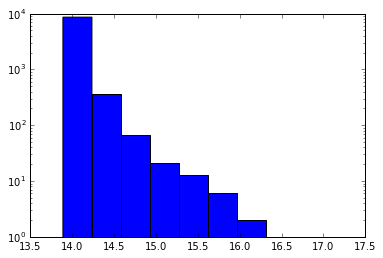

In [25]:
plt.hist(mtrue)
plt.yscale('log')

In [ ]:
print fit_old.log_prob(fit_old.unconstrain_pars({"lnA":fit_old.get_posterior_mean()[0,0],
                                           "alpha":fit_old.get_posterior_mean()[1,0],
                                           "logx_min":fit_old.get_posterior_mean()[2,0],
                                           "logx":fit_old.get_posterior_mean()[3:-1,0]}))

print fit_old.log_prob(fit_old.unconstrain_pars({"lnA":31.0,
                                           "alpha":0.8,
                                           "logx_min":12.0,
                                           "logx":data_old['logx_meas']}))

/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: overflow encountered in power
/home/steven/anaconda2/lib/python2.7/site-packages/matplotlib/ticker.py:1593: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades


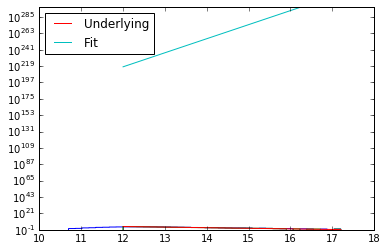

In [21]:
fit_pdf,model_pdf,data_pdf, underlying_pdf = run_hierarchical_on_complex(0.8,12.0,31.0,hierarchical_model_variable_mmin_pdf,0.4,iter=500,warmup=100,chains=4,n_jobs=4,old_style=True)

In [22]:
fit_pdf

Inference for Stan model: pareto_hierarchical_706b4603f9557532457ec9da56f82bc8.
4 chains, each with iter=500; warmup=100; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha      3.99  3.7e-4 8.6e-3   3.97   3.99   3.99    4.0    4.0  534.0    1.0
logx_min  12.44  2.8e-4 6.4e-3  12.43  12.44  12.44  12.44  12.45  522.0    1.0
lp__     -2.9e5    4.41  76.64 -2.9e5 -2.9e5 -2.9e5 -2.9e5 -2.9e5  302.0   1.01

Samples were drawn using NUTS(diag_e) at Mon May 16 17:32:27 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

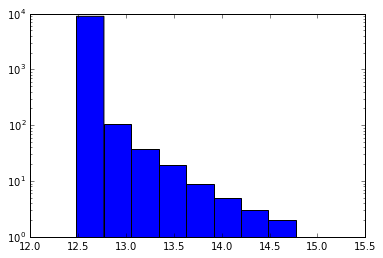

In [24]:
plt.hist(fit_pdf.get_posterior_mean()[3:-1,0])
plt.yscale('log')